In [ ]:
import os
import sys
import numpy as np
from pathlib import Path
from skimage.io import imread
import matplotlib.pyplot as plt

# Current folder as project_root (3 levels up)
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", "..", ".."))
src_dir      = os.path.join(project_root)
if src_dir not in sys.path:
    sys.path.insert(0, src_dir)

import importlib
import src.Dice_Score
importlib.reload(src.Dice_Score)

from src.pre_processing import gammacorrection
from src.Complete_Otsu_Global import otsu_threshold_skimage_like
from src.Dice_Score import dice_score

# Provided loader functions (unchanged)
from src.imread_all import (
    load_nih3t3_images,
    load_n2dl_hela_images,
    load_n2dh_gowt1_images,
)

def calculate_dice_scores_gamma_global(imgs, gts, gamma):
    """
    Process all images and corresponding ground truths to compute
    Dice scores at the specified gamma value.
    """
    dice_scores = []
    for img, gt in zip(imgs, gts):
        # Binarize groundtruth
        gt_bin = (gt > 0).astype(np.uint8)

        # Gamma correction
        img_gamma = gammacorrection(img, gamma=gamma)

        # Global Otsu thresholding
        t = otsu_threshold_skimage_like(img_gamma)
        binary1 = (img_gamma > t).astype(np.uint8)

        # Calculate Dice score
        score = dice_score(binary1.flatten(), gt_bin.flatten())
        dice_scores.append(score)

    return dice_scores

def evaluate_datasets(datasets, gamma_values, base_path):
    """
    Runs evaluation loop over given datasets and gamma sweep,
    combines all mean Dice scores into one 2D array
    (columns: datasets, rows: gamma values) and returns it.
    """
    all_means_list = []

    for name, loader in datasets:
        # Load images & ground truths
        imgs, gts, _, _ = loader(
            base_path=os.path.join(project_root, "data-git", name)
        )

        dice_means = []
        print(f"=== Processing {name} ===")
        for gamma in gamma_values:
            # Pass current gamma into the calculator
            scores = calculate_dice_scores_gamma_global(imgs, gts, gamma)
            mean_score = np.mean(scores)
            print(f"Gamma {gamma:.2f} → Mean Dice: {mean_score:.4f}")
            dice_means.append(mean_score)

        all_means_list.append(dice_means)

    # Stack per-dataset lists and transpose → shape (num_gammas, num_datasets)
    all_means = np.vstack(all_means_list).T
    return all_means

def find_best_gamma(all_means, gamma_values):
    """
    Finds the gamma that maximizes the average Dice score across datasets.
    """
    mean_across = np.mean(all_means, axis=1)
    best_idx    = np.argmax(mean_across)
    return gamma_values[best_idx], mean_across[best_idx]

def plot_mean_dice_vs_gamma(gamma_values, all_means, dataset_names):
    """
    Plot mean Dice score vs. gamma for each dataset.
    """
    plt.figure(figsize=(10, 6))
    for idx, name in enumerate(dataset_names):
        plt.plot(
            gamma_values,
            all_means[:, idx],
            marker='o',
            linestyle='-',
            label=name
        )
    plt.xlabel('Gamma value')
    plt.ylabel('Mean Dice score')
    plt.title('Mean Dice Score vs. Gamma')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    gamma_values = np.arange(0.1, 2.1, 0.1)
    datasets = [
        ('N2DH-GOWT1', load_n2dh_gowt1_images),
        ('N2DL-HeLa', load_n2dl_hela_images),
        ('NIH3T3',  load_nih3t3_images),
    ]

    all_means_gamma = evaluate_datasets(datasets, gamma_values)

    best_gamma, best_dice = find_best_gamma(all_means_gamma, gamma_values)
    print(f"Optimal gamma value: {best_gamma:.2f}  Mean Dice = {best_dice:.4f}")

    dataset_names = [name for name, _ in datasets]
    plot_mean_dice_vs_gamma(gamma_values, all_means_gamma, dataset_names)

=== Processing N2DH-GOWT1 ===
Gamma 0.10 → Mean Dice: 0.2934
Gamma 0.20 → Mean Dice: 0.2934
Gamma 0.30 → Mean Dice: 0.2934
Gamma 0.40 → Mean Dice: 0.2934
Gamma 0.50 → Mean Dice: 0.4482
Gamma 0.60 → Mean Dice: 0.6783
Gamma 0.70 → Mean Dice: 0.6879
Gamma 0.80 → Mean Dice: 0.6401
Gamma 0.90 → Mean Dice: 0.5958
Gamma 1.00 → Mean Dice: 0.5471
Gamma 1.10 → Mean Dice: 0.4716
Gamma 1.20 → Mean Dice: 0.4440
Gamma 1.30 → Mean Dice: 0.3843
Gamma 1.40 → Mean Dice: 0.3571
Gamma 1.50 → Mean Dice: 0.3164
Gamma 1.60 → Mean Dice: 0.3009
Gamma 1.70 → Mean Dice: 0.2712
Gamma 1.80 → Mean Dice: 0.2441
Gamma 1.90 → Mean Dice: 0.2359
Gamma 2.00 → Mean Dice: 0.2152
=== Processing N2DL-HeLa ===
Gamma 0.10 → Mean Dice: 0.8865
Gamma 0.20 → Mean Dice: 0.8828
Gamma 0.30 → Mean Dice: 0.8753
Gamma 0.40 → Mean Dice: 0.8623
Gamma 0.50 → Mean Dice: 0.8453
Gamma 0.60 → Mean Dice: 0.8238
Gamma 0.70 → Mean Dice: 0.7966
Gamma 0.80 → Mean Dice: 0.7738
Gamma 0.90 → Mean Dice: 0.7441
Gamma 1.00 → Mean Dice: 0.7164
Gamma 1.10 

KeyboardInterrupt: 

=== Processing N2DH-GOWT1 ===
Gamma 0.10 → Mean Dice: 0.6056
Gamma 0.20 → Mean Dice: 0.6057
Gamma 0.30 → Mean Dice: 0.6101
Gamma 0.40 → Mean Dice: 0.6174
Gamma 0.50 → Mean Dice: 0.6409
Gamma 0.60 → Mean Dice: 0.6471
Gamma 0.70 → Mean Dice: 0.6524
Gamma 0.80 → Mean Dice: 0.6407
Gamma 0.90 → Mean Dice: 0.6235
Gamma 1.00 → Mean Dice: 0.5967
Gamma 1.10 → Mean Dice: 0.5725
Gamma 1.20 → Mean Dice: 0.5464
Gamma 1.30 → Mean Dice: 0.5266
Gamma 1.40 → Mean Dice: 0.5049
Gamma 1.50 → Mean Dice: 0.4714
Gamma 1.60 → Mean Dice: 0.4496
Gamma 1.70 → Mean Dice: 0.4241
Gamma 1.80 → Mean Dice: 0.4025
Gamma 1.90 → Mean Dice: 0.3737
Gamma 2.00 → Mean Dice: 0.3468
Gamma 2.10 → Mean Dice: 0.3239
Gamma 2.20 → Mean Dice: 0.3052
Gamma 2.30 → Mean Dice: 0.2847
Gamma 2.40 → Mean Dice: 0.2586
Gamma 2.50 → Mean Dice: 0.2371
Gamma 2.60 → Mean Dice: 0.2251
Gamma 2.70 → Mean Dice: 0.1993
Gamma 2.80 → Mean Dice: 0.1892
Gamma 2.90 → Mean Dice: 0.1735
Gamma 3.00 → Mean Dice: 0.1544
=== Processing N2DL-HeLa ===
Gamma 0.10 

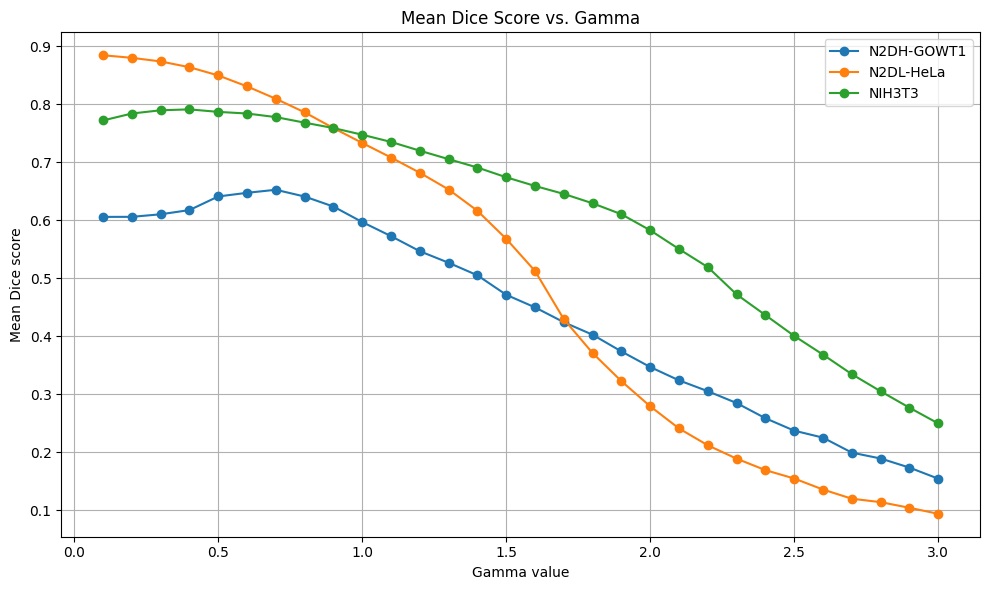

In [5]:
import os
import sys
import numpy as np
from pathlib import Path
from skimage.io import imread
import matplotlib.pyplot as plt

# Current folder as project_root (3 levels up)
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", "..", ".."))
src_dir      = os.path.join(project_root)
if src_dir not in sys.path:
    sys.path.insert(0, src_dir)

import importlib
import src.Dice_Score
importlib.reload(src.Dice_Score)

from src.pre_processing import gammacorrection
from src.Complete_Otsu_Global import otsu_threshold_skimage_like
from src.Otsu_Local import local_otsu_package
from src.Dice_Score import dice_score

# Provided loader functions (unchanged)
from src.imread_all import (
    load_nih3t3_images,
    load_n2dl_hela_images,
    load_n2dh_gowt1_images,
)

def calculate_dice_scores_gamma_global(imgs, gts, gamma):
    """
    Process all images and corresponding ground truths to compute
    Dice scores at the specified gamma value.
    """
    dice_scores = []
    for img, gt in zip(imgs, gts):
        # Binarize groundtruth
        gt_bin = (gt > 0).astype(np.uint8)

        # Gamma correction
        img_gamma = gammacorrection(img, gamma=gamma)

        # Global Otsu thresholding
        t = local_otsu_package(img_gamma, radius=255)
        binary1 = (img_gamma > t).astype(np.uint8)

        # Calculate Dice score
        score = dice_score(binary1.flatten(), gt_bin.flatten())
        dice_scores.append(score)

    return dice_scores

def evaluate_datasets(datasets, gamma_values):
    """
    Runs evaluation loop over given datasets and gamma sweep,
    combines all mean Dice scores into one 2D array
    (columns: datasets, rows: gamma values) and returns it.
    """
    all_means_list = []

    for name, loader in datasets:
        # Load images & ground truths
        imgs, gts, _, _ = loader(
            base_path=os.path.join(project_root, "data-git", name)
        )

        dice_means = []
        print(f"=== Processing {name} ===")
        for gamma in gamma_values:
            # Pass current gamma into the calculator
            scores = calculate_dice_scores_gamma_global(imgs, gts, gamma)
            mean_score = np.mean(scores)
            print(f"Gamma {gamma:.2f} → Mean Dice: {mean_score:.4f}")
            dice_means.append(mean_score)

        all_means_list.append(dice_means)

    # Stack per-dataset lists and transpose → shape (num_gammas, num_datasets)
    all_means = np.vstack(all_means_list).T
    return all_means

def find_best_gamma(all_means, gamma_values):
    """
    Finds the gamma that maximizes the average Dice score across datasets.
    """
    mean_across = np.mean(all_means, axis=1)
    best_idx    = np.argmax(mean_across)
    return gamma_values[best_idx], mean_across[best_idx]

def plot_mean_dice_vs_gamma(gamma_values, all_means, dataset_names):
    """
    Plot mean Dice score vs. gamma for each dataset.
    """
    plt.figure(figsize=(10, 6))
    for idx, name in enumerate(dataset_names):
        plt.plot(
            gamma_values,
            all_means[:, idx],
            marker='o',
            linestyle='-',
            label=name
        )
    plt.xlabel('Gamma value')
    plt.ylabel('Mean Dice score')
    plt.title('Mean Dice Score vs. Gamma')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    gamma_values = np.arange(0.1, 3.1, 0.1)
    datasets = [
        ('N2DH-GOWT1', load_n2dh_gowt1_images),
        ('N2DL-HeLa', load_n2dl_hela_images),
        ('NIH3T3',  load_nih3t3_images),
    ]

    all_means_gamma = evaluate_datasets(datasets, gamma_values)

    best_gamma, best_dice = find_best_gamma(all_means_gamma, gamma_values)
    print(f"Optimal gamma value: {best_gamma:.2f}  Mean Dice = {best_dice:.4f}")

    dataset_names = [name for name, _ in datasets]
    plot_mean_dice_vs_gamma(gamma_values, all_means_gamma, dataset_names)